## Titanic dataset

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

First, login to [Kaggle](https://www.kaggle.com/) and go to the [Titanic challenge](https://www.kaggle.com/c/titanic) to download `train.csv` and `test.csv`. Save them to the `datasets/titanic` directory.

Next, let's load the data:

In [2]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [3]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Let's get more info to see how much data is missing:

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Yikes, only 38% **Survived**. :(  That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [8]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [9]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Now let's build our preprocessing pipelines. We will reuse the `DataframeSelector` we built in the previous chapter to select specific attributes from the `DataFrame`:

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Let's build the pipeline for the numerical attributes:

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", Imputer(strategy="median")),
    ])

In [14]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We will also need an imputer for the string categorical columns (the regular `Imputer` does not work on those):

In [15]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

We can convert each categorical value to a one-hot vector using a `OneHotEncoder`. Right now this class can only handle integer categorical inputs, but in Scikit-Learn 0.20 it will also handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)). So for now we import it from `future_encoders.py`, but when Scikit-Learn 0.20 is released, you can import it from `sklearn.preprocessing` instead:

In [16]:
from future_encoders import OneHotEncoder

Now we can build the pipeline for the categorical attributes:

In [17]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [18]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Finally, let's join the numerical and categorical pipelines:

In [19]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [20]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Let's not forget to get the labels:

In [21]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with an `SVC`:

In [22]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Great, our model is trained, let's use it to make predictions on the test set:

In [23]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [24]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

Okay, over 73% accuracy, clearly better than random chance, but it's not a great score. Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that you need to reach above 80% accuracy to be within the top 10% Kagglers. Some reached 100%, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! ;-) So let's try to build a model that reaches 80% accuracy.

Let's try a `RandomForestClassifier`:

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8115690614005221

That's much better!

Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

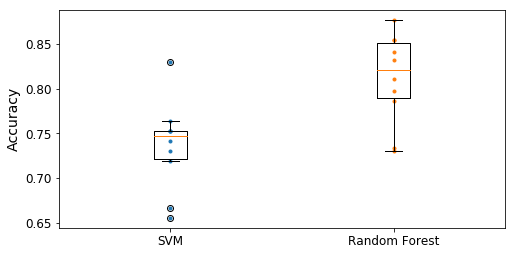

In [26]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * replace **SibSp** and **Parch** with their sum,
  * try to identify parts of names that correlate well with the **Survived** attribute (e.g. if the name contains "Countess", then survival seems more likely),
* try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).

In [27]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [28]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


# Logistic Regression

In [36]:
# Basics
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

# Sampling
from sklearn.model_selection import train_test_split

# Classifiier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import accuracy_score

%matplotlib inline
sns.set(color_codes=True)
pal = sns.color_palette("Set2", 10)
sns.set_palette(pal)

TitanicTrain = pd.read_csv("datasets/titanic/train.csv")
TitanicTrain.columns, TitanicTrain.shape 

(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'), (891, 12))

In [37]:
TitanicTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


/Users/bridgetfranciscovich/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/bridgetfranciscovich/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


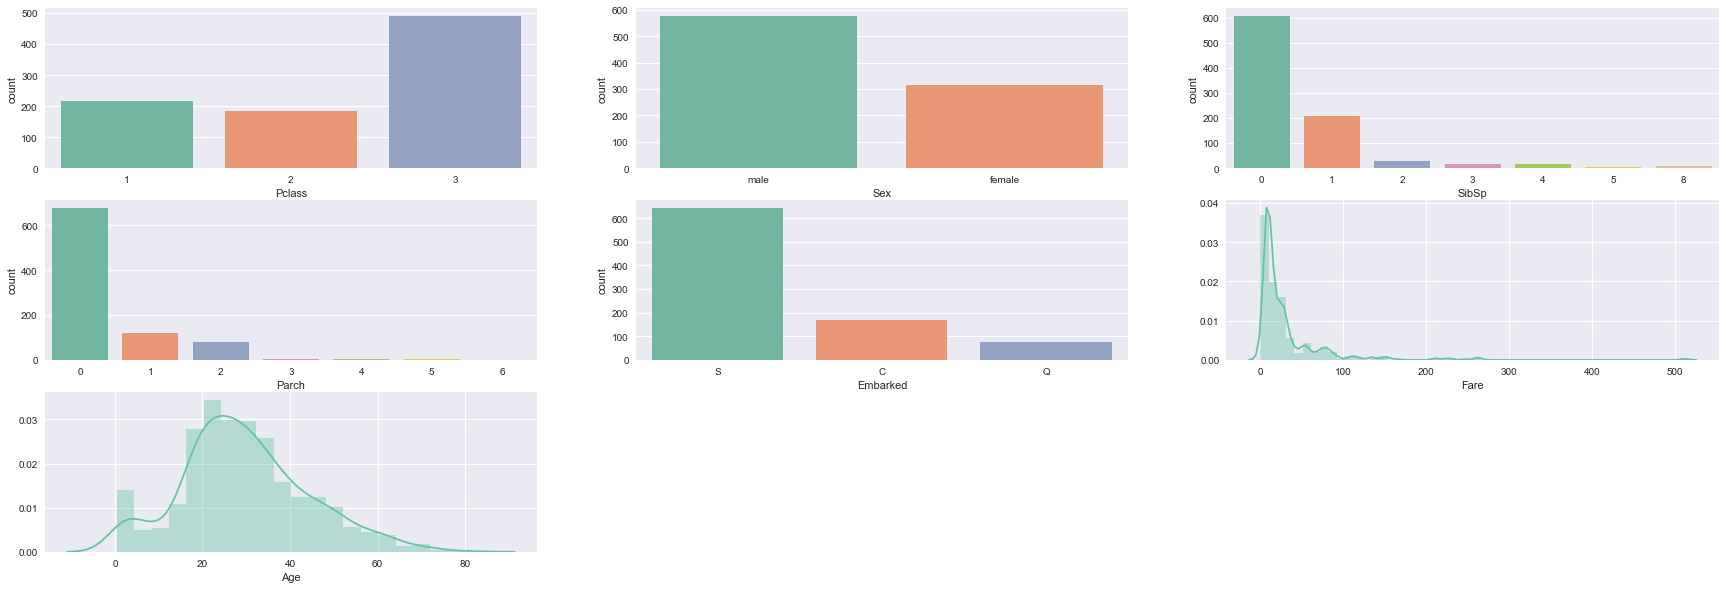

In [39]:
categ =  [ 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
conti = ['Fare', 'Age']

#Distribution
fig = plt.figure(figsize=(30, 10))
for i in range (0,len(categ)):
    fig.add_subplot(3,3,i+1)
    sns.countplot(x=categ[i], data=TitanicTrain);  

for col in conti:
    fig.add_subplot(3,3,i + 2)
    sns.distplot(TitanicTrain[col].dropna());
    i += 1
    
plt.show()
fig.clear()


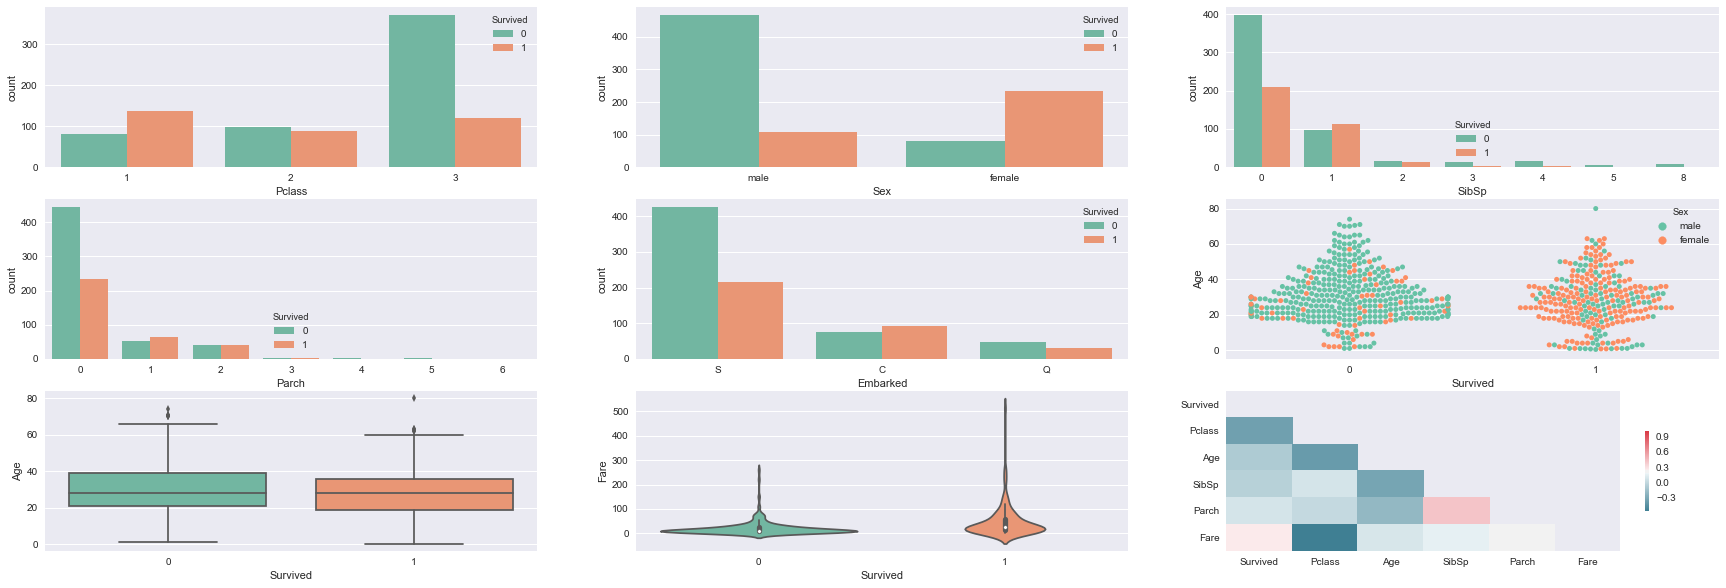

In [40]:
fig = plt.figure(figsize=(30, 10))
i = 1
for col in categ:
    if col != 'Survived':
        fig.add_subplot(3,3,i)
        sns.countplot(x=col, data=TitanicTrain,hue='Survived');
        i += 1

# Box plot survived x age
fig.add_subplot(3,3,6)
sns.swarmplot(x="Survived", y="Age", hue="Sex", data=TitanicTrain);
fig.add_subplot(3,3,7)
sns.boxplot(x="Survived", y="Age", data=TitanicTrain)

# fare and Survived
fig.add_subplot(3,3,8)
sns.violinplot(x="Survived", y="Fare", data=TitanicTrain)

# correlations with the new features
corr = TitanicTrain.drop(['PassengerId'], axis=1).corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig.add_subplot(3,3,9)
sns.heatmap(corr, mask=mask, cmap=cmap, cbar_kws={"shrink": .5})
plt.show()
fig.clear()

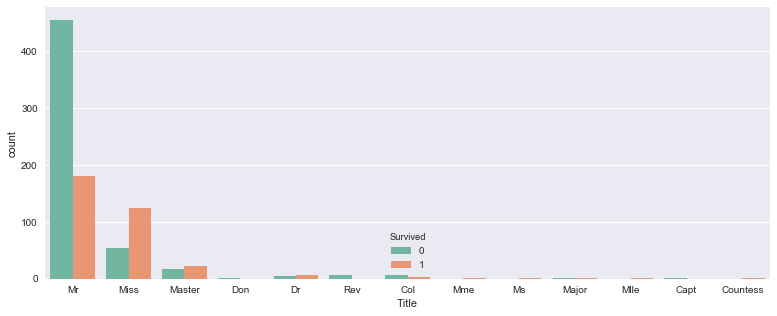

In [42]:
title = ['Mlle','Mrs', 'Mr', 'Miss','Master','Don','Rev','Dr','Mme','Ms','Major','Col','Capt','Countess']

def ExtractTitle(name):
    tit = 'missing'
    for item in title :
        if item in name:
            tit = item
    if tit == 'missing':
        tit = 'Mr'
    return tit

TitanicTrain["Title"] = TitanicTrain.apply(lambda row: ExtractTitle(row["Name"]),axis=1)
plt.figure(figsize=(13, 5))
fig.add_subplot(2,1,1)
sns.countplot(x='Title', data=TitanicTrain,hue='Survived');

In [43]:
# Age
MedianAge = TitanicTrain.Age.median()
TitanicTrain.Age = TitanicTrain.Age.fillna(value=MedianAge)
# Embarked replace NaN with the mode value
ModeEmbarked = TitanicTrain.Embarked.mode()[0]
TitanicTrain.Embarked = TitanicTrain.Embarked.fillna(value=ModeEmbarked)
# Fare have 1 NaN missing value on the Submission dataset
MedianFare = TitanicTrain.Fare.median()
TitanicTrain.Fare = TitanicTrain.Fare.fillna(value=MedianFare)

In [45]:
TitanicTrain["Cabin"] = TitanicTrain.apply(lambda obs: "No" if pd.isnull(obs['Cabin']) else "Yes", axis=1)
TitanicTrain = pd.get_dummies(TitanicTrain,drop_first=True,columns=['Sex','Title','Cabin','Embarked'])

In [46]:
scale = StandardScaler().fit(TitanicTrain[['Age', 'Fare']])
TitanicTrain[['Age', 'Fare']] = scale.transform(TitanicTrain[['Age', 'Fare']])

In [47]:
Target = TitanicTrain.Survived
Features = TitanicTrain.drop(['Survived','Name','Ticket','PassengerId'],axis=1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.3, random_state=42)
Target = TitanicTrain.Survived

MlRes= {}
def MlResult(model,score):
    MlRes[model] = score
    print(MlRes)
    
roc_curve_data = {}
def ConcatRocData(algoname, fpr, tpr, auc):
    data = [fpr, tpr, auc]
    roc_curve_data[algoname] = data    

In [48]:
# Logistic Regression : 
logi_reg = LogisticRegression()
# Fit the regressor to the training data
logi_reg.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred = logi_reg.predict(X_test)

# Score / Metrics
accuracy = logi_reg.score(X_test, y_test)
MlResult('Logistic Regression',accuracy)

{'Logistic Regression': 0.8283582089552238}


In [49]:
# Create a random Forest Classifier instance
rfc = RandomForestClassifier(n_estimators = 100)
# Fit to the training data
rfc.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred = rfc.predict(X_test)

# Score / Metrics
accuracy = rfc.score(X_test, y_test) # = accuracy
MlResult('Random Forest',accuracy)

{'Logistic Regression': 0.8283582089552238, 'Random Forest': 0.7985074626865671}


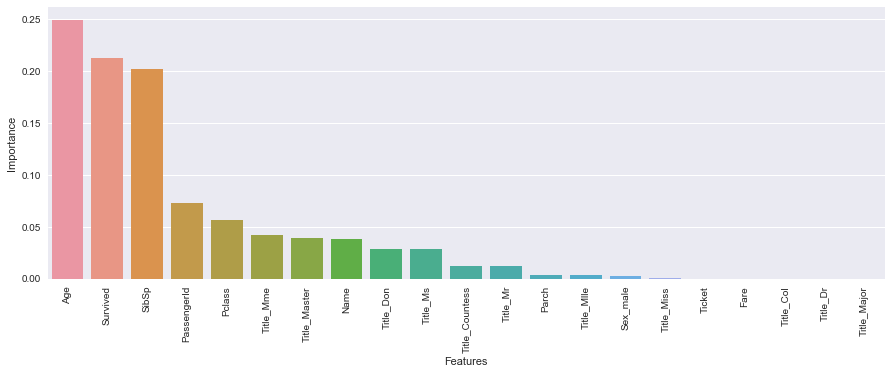

In [50]:
#Features importance
def FeaturesImportance(data,model):
    features = data.columns.tolist()
    fi = model.feature_importances_
    sorted_features = {}
    for feature, imp in zip(features, fi):
        sorted_features[feature] = round(imp,3)

    # sort the dictionnary by value
    sorted_features = OrderedDict(sorted(sorted_features.items(),reverse=True, key=lambda t: t[1]))

    #for feature, imp in sorted_features.items():
        #print(feature+" : ",imp)

    dfvi = pd.DataFrame(list(sorted_features.items()), columns=['Features', 'Importance'])
    #dfvi.head()
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Features', y='Importance', data=dfvi);
    plt.xticks(rotation=90) 
    plt.show()
    
#Features importance
FeaturesImportance(TitanicTrain,rfc)